Found 85958 images belonging to 96 classes.
Found 24518 images belonging to 96 classes.
Found 12212 images belonging to 96 classes.
Number of classes (training): 96
Number of classes (validation): 96
Number of classes (test): 96
Sample images from the validation set:
(32, 224, 224, 3) (32, 96)
(32, 224, 224, 3) (32, 96)
(32, 224, 224, 3) (32, 96)


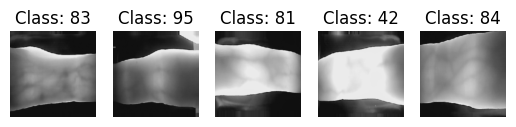

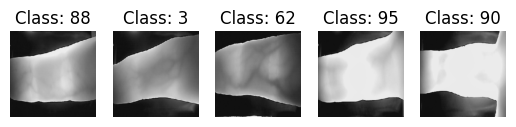

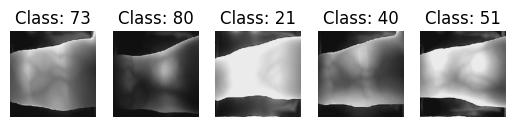

Epoch 1/5
2687/2687 [==============================] - 655s 241ms/step - loss: 4.1378 - accuracy: 0.0853 - val_loss: 3.7079 - val_accuracy: 0.1537
Epoch 2/5
2687/2687 [==============================] - 647s 241ms/step - loss: 3.3200 - accuracy: 0.2338 - val_loss: 3.0253 - val_accuracy: 0.2771
Epoch 3/5
2687/2687 [==============================] - 631s 235ms/step - loss: 2.7013 - accuracy: 0.3537 - val_loss: 2.5591 - val_accuracy: 0.3679
Epoch 4/5
2687/2687 [==============================] - 624s 232ms/step - loss: 2.2513 - accuracy: 0.4442 - val_loss: 2.2927 - val_accuracy: 0.4099
Epoch 5/5
382/382 [==============================] - 22s 57ms/step - loss: 2.0161 - accuracy: 0.4758
Test Loss: 2.0160574913024902
Test Accuracy: 0.4758434295654297


: 

In [1]:
# import cv2
##TODO : REMOVE VALIDATION SET- ISME convert into sets wale me dikkat aayegi
##TODO : DONT USE AUGMENTED DATA ON TRAINING SET
##TODO : LOOK INTO THE LAYERS WHERE ACT FUNC ARE RELU BUT IN MOBILENET V2 WE DONT USE RELU
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# from PIL import Image

# Define paths to the finger vein dataset directory
data_dir = "FVData"
train_dir= "FVData/train"
val_dir = "FVData/validation"
test_dir = "FVData/test"

# Split the dataset into training and validation sets
# train_dir, val_dir = train_test_split(os.listdir(data_dir), test_size=0.2, random_state=42)

# Image preprocessing function
def preprocess_image(img):
    # Customize this function based on your preprocessing requirements
    return img / 255.0  # Normalize to the range [0, 1]

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Additional checks
print("Number of classes (training):", len(train_generator.class_indices))
print("Number of classes (validation):", len(validation_generator.class_indices))
print("Number of classes (test):", len(test_generator.class_indices))

# print("Number of images in validation set:", validation_generator.samples)

# Display a few images from the training generator
print("Sample images from the validation set:")
for _ in range(3):
    batch = validation_generator.next()
    print(batch[0].shape, batch[1].shape)
    


# print(len(validation_generator))
import matplotlib.pyplot as plt

# Display a few images from the training generator
def show_images(generator, num_images=5):
    class_labels = list(generator.class_indices.keys())
    batch = generator.next()
    images, labels = batch

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_labels[np.argmax(labels[i])]}")
        plt.axis("off")

    plt.show()

# Display images from the training generator
show_images(train_generator, num_images=5)

# Display images from the validation generator
show_images(validation_generator, num_images=5)

#Display images from test generator
show_images(test_generator,num_images=5)

# Model definition
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    layers.BatchNormalization(), # Additional dense layer
    # tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    Dense(128, activation="relu"),
    layers.BatchNormalization(),
    Dense(64, activation="relu"),
    layers.BatchNormalization(),
    Dense(32, activation="relu"),
    layers.BatchNormalization(), # Additional dense layer
    Dense(len(train_generator.class_indices), activation="softmax")
])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Set up EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fine-tuning: Unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True
    
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)
# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
# Example usage for predicting an unknown finger vein image
# unknown_finger_path = "SCUT FV Dataset/session1_ROI/session1_ROI/1/1_1_0_0_1.bmp"
# predicted_class = model.predict(train_datagen.flow(np.expand_dims(preprocess_image(cv2.imread(unknown_finger_path)), axis=0)))
# print(f"Predicted class: {predicted_class}")
# unknown_finger_path = "sample_dataset/short_sample/3/3_1_0_0_1.bmp"
# predicted_class_probabilities = model.predict(train_datagen.flow(np.expand_dims(preprocess_image(cv2.imread(unknown_finger_path)), axis=0)))
# # predicted_class = np.argmax(predicted_class_probabilities, axis=1)[0]
# predicted_class_label = list(train_generator.class_indices.keys())[predicted_class]
# print(f"Predicted class: {predicted_class}")

In [7]:
unknown_finger_path = "collected_final/2/2_1_0_0_1.bmp"
from tensorflow.keras.preprocessing import image

# Example usage for predicting an unknown finger vein image
# Load and preprocess the image
unknown_finger_img = image.load_img(unknown_finger_path, target_size=(224, 224))
unknown_finger_img_array = image.img_to_array(unknown_finger_img)
unknown_finger_img_array = preprocess_image(unknown_finger_img_array)
unknown_finger_img_array = np.expand_dims(unknown_finger_img_array, axis=0)

# Predict the class probabilities
predicted_class_probabilities = model.predict(unknown_finger_img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predicted_class_probabilities, axis=1)[0]

# Map the class index to the actual class label using the data generator's class_indices
class_label = list(train_generator.class_indices.keys())[predicted_class_index]

print(f"Predicted class: {class_label}")

1/1 [==============================] - 1s 729ms/step
Predicted class: 2
